# HF Trainer

In [ ]:
!pip install transformers

In [9]:
# Colab Stuff
from google.colab import drive
drive.mount('/content/drive/')
#import os
#os.listdir("./drive/MyDrive/img/")

Mounted at /content/drive/


In [ ]:
# Unzip
#import zipfile
#with zipfile.ZipFile("./drive/MyDrive/img/imagenet-mini.zip", mode="r") as archive:
#  archive.extractall("./drive/MyDrive/img/i")

In [10]:
# HuggingFace.py
from transformers import pipeline
from typing import List, Dict, Tuple
import numpy as np
from pathlib import Path
import pickle
import gc


class HuggingFaceImageClassifier:
    model_name = ""
    index_file = ""
    pipe = None
    index = None

    def __init__(self, model_name: str = "google/vit-base-patch16-224", 
                 index_file: str = "./data/index_hf.pickle"):
        self.model_name = model_name        
        self.index_file = index_file
        self.pipe = pipeline(task="image-classification", model=self.model_name)
        self.index = self.__load_index(self.index_file)
        
    def predict_image(self, image_path: str, top_k: int = 1000) -> List[Dict[float, str]]:
        return self.pipe(image_path, top_k=top_k)

    def __extract_features(self, image_path: str) -> Tuple[List[float], str]:
        result = self.predict_image(image_path)
        top_class = result[0]["label"]
        features = sorted(result, key=lambda x: x["label"])
        features = [round(x["score"], 6) for x in features]
        return (features, top_class)

    def create_index(self, image_repo: str) -> None:
        images = list(Path(image_repo).iterdir())
        for i, image in enumerate(images):
            print(f"Processing {image.name}, Length of index {len(self.index)}")
            name = image.name
            features, top_class = self.__extract_features(image.resolve().__str__())
            self.index.append({"name": name, "top_class": top_class, "features": features})

            if i % 10 == 0 and i != 0: 
                print(f"Write index to {self.index_file}, Length: {len(self.index)}")                
                with open(self.index_file, "wb") as f:
                    pickle.dump(self.index, f, protocol=pickle.HIGHEST_PROTOCOL)
                gc.collect()            # garbage collection

    def __load_index(self, index_file: str):
        if Path(index_file).exists() == False:
            print(f"Index file {index_file} not found. Please use create_index().")  
            return []
        with open(index_file, "rb") as f:
            index = pickle.load(f)
            return index

    def __cosine_similarity(self, a: List[float], b: List[float]):
        a, b = np.array(a), np.array(b)
        return np.dot(a,b) / ( np.linalg.norm(a) * np.linalg.norm(b) )


    def find_similar_images(self, image_path: str, top_k: int = 10) -> List[Tuple[str, float]]:
        features, top_class = self.__extract_features(image_path)
        similar_images = list()

        for i, image in enumerate(self.index):
            if image["top_class"] == top_class:
                score = self.__cosine_similarity(features, image["features"])
                similar_images.append((image["name"], score))
        
        similar_images = sorted(similar_images, key=lambda x: x[1], reverse=True)
        return similar_images[:top_k]

In [ ]:
clf = HuggingFaceImageClassifier(index_file="./drive/MyDrive/data/index_hf.pickle")
clf.create_index("./drive/MyDrive/imagenet-mini")

In [ ]:
# Move Trained Files
data = pickle.load(open("./drive/MyDrive/data/index_hf.pickle", "rb"))

for image in data:
  try: 
    old = Path("./drive/MyDrive/imagenet-mini/", image["name"])
    new = Path("./drive/MyDrive/imagenet-mini-trained/", image["name"])
    old.rename(new)
    print(f"Moving {image['name']}")
  except FileNotFoundError as e:
    next

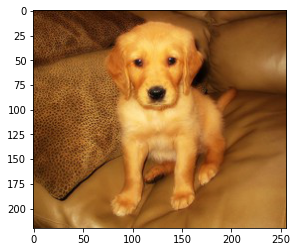

In [ ]:
## Image Check
uploaded_img = "./drive/MyDrive/img/dog_input.jpg"
similar_images = clf.find_similar_images(uploaded_img)

from PIL import Image
import matplotlib.pyplot as plt

im = Image.open(f"./drive/MyDrive/imagenet-mini/{similar_images[4][0]}")
plt.imshow(im)